# The Titanic Competition ML Prediction

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pprint
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
try:
    for dirname, _, filenames in os.walk('../kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
except:
    for dirname, _, filenames in os.walk('../kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

try:
    for dirname, _, filenames in os.walk('../kaggle/working'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
except:
    for dirname, _, filenames in os.walk('../kaggle/working'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
       

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../kaggle/input/titanic/gender_submission.csv
../kaggle/input/titanic/test.csv
../kaggle/input/titanic/train.csv
../kaggle/working/train_data_binned_onehot.csv
../kaggle/working/test_data_binned_onehot.csv
../kaggle/working/submission_data.csv


Load the data which was precprocessed in the `Titanic Wrangler Age Bin` notebook

In [2]:
train_data = pd.read_csv("../kaggle/working/train_data_binned_onehot.csv", index_col=0)
test_data = pd.read_csv("../kaggle/working/test_data_binned_onehot.csv", index_col=0)



Test for lingering NaN values

In [3]:
test_data[test_data.isna()].count()

Age               0
AgeBin_Adult      0
AgeBin_Child      0
AgeBin_Old        0
AgeBin_Unknown    0
AgeBin_Youth      0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
Embarked_U        0
Fare              0
Parch_0           0
Parch_1           0
Parch_2           0
Parch_3           0
Parch_4           0
Parch_5           0
Parch_6           0
Parch_9           0
PassengerId       0
Pclass_1          0
Pclass_2          0
Pclass_3          0
Section_A         0
Section_B         0
Section_C         0
Section_D         0
Section_E         0
Section_F         0
Section_G         0
Section_T         0
Section_X         0
Sex_female        0
Sex_male          0
SibSp_0           0
SibSp_1           0
SibSp_2           0
SibSp_3           0
SibSp_4           0
SibSp_5           0
SibSp_8           0
cluster           0
dtype: int64

In [4]:
test_data.dtypes

Age               float64
AgeBin_Adult        int64
AgeBin_Child        int64
AgeBin_Old          int64
AgeBin_Unknown      int64
AgeBin_Youth        int64
Embarked_C          int64
Embarked_Q          int64
Embarked_S          int64
Embarked_U          int64
Fare              float64
Parch_0             int64
Parch_1             int64
Parch_2             int64
Parch_3             int64
Parch_4             int64
Parch_5             int64
Parch_6             int64
Parch_9             int64
PassengerId         int64
Pclass_1            int64
Pclass_2            int64
Pclass_3            int64
Section_A           int64
Section_B           int64
Section_C           int64
Section_D           int64
Section_E           int64
Section_F           int64
Section_G           int64
Section_T           int64
Section_X           int64
Sex_female          int64
Sex_male            int64
SibSp_0             int64
SibSp_1             int64
SibSp_2             int64
SibSp_3             int64
SibSp_4     

## Helper functions and stuff
This is the place for all helper functions

In [5]:
# control randomness
np.random.seed=0

# create a dict of models to try with a grid search
models = {
    "logr-lbfgs": LogisticRegression(),
    "logr-linear": LogisticRegression(),
    "logr-newton-cg": LogisticRegression(),
    "dt": DecisionTreeClassifier(),
    "svm": SVC(),
    "knn": KNeighborsClassifier(),
    "rf": RandomForestClassifier(),
    "sgd": SGDClassifier() 
}
# create a matching dict of parameters for each grid search
params = {
    "logr-lbfgs": {"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']},
    "logr-linear": {"C":[0.01,0.1,1],'penalty':['l2', 'l1'], 'solver':['liblinear']},
    "logr-newton-cg": {"C":[0.01,0.1,1],'penalty':['l2', 'none'], 'solver':['newton-cg']},
    "dt": {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['log2', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]},
    "svm": {'kernel':('linear', 'rbf','poly', 'sigmoid'),
              'C': [0.01, 0.1, 1.0],
              'max_iter': [10000]},
    "knn": {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1,2]},
    "rf": {"n_estimators": [100, 200, 500, 1000],
            "criterion": ["gini", "entropy", "log_loss"],
            "min_samples_split": [2,4,6],
            "max_features": ["sqrt","log2"],
            "bootstrap": [True, False]
          },
    "sgd": { "loss": ["hinge", "log_loss", "modified_huber"]}
}
grids = {}
for koko in models.keys():
    grids[koko] = GridSearchCV(models[koko],params[koko],cv=5, n_jobs=10, refit=True)

def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    plt.figure(figsize=(20,20))
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not survive', 'survived']); ax.yaxis.set_ticklabels(['did not survive', 'survived'])
    
def rungrids(Xtrain, Xtest, ytrain, ytest):
    """Takes xtrain, xtest, ytrain, ytest data and runs them
    through the grid search for all models and returns
    predictors: a dict of trained models which are the best from the grid search
    scores: a dict with scores for the models
    f_ones: a dict of F1 scores for the predictions
    yhats: a dict of predicted values for making confusion matrices."""
    predictors = {}
    scores = {}
    f_ones = {}
    yhats = {}
    for k in models.keys():
        print(f"Fitting {k}")
        predictors[k] = grids[k].fit(Xtrain, ytrain)
        # print(f"Scoring {k}")
        scores[k] = predictors[k].score(Xtest, ytest)
        # print(f"Predicting {k}")
        yhats[k] = predictors[k].predict(Xtest)
        # print(f"F1 Scoring {k}")
        f_ones[k] = f1_score(ytest, yhats[k])
    return predictors, scores, f_ones, yhats


In [6]:
train_data.describe()

,Age,AgeBin_Adult,AgeBin_Child,AgeBin_Old,AgeBin_Unknown,AgeBin_Youth,Embarked_C,Embarked_Q,Embarked_S,Embarked_U,...,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,cluster,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,23.600640,0.484848,0.071829,0.115600,0.198653,0.129068,0.188552,0.086420,0.722783,0.002245,...,0.647587,0.682379,0.234568,0.031425,0.017957,0.020202,0.005612,0.007856,5.851852,0.383838
std,17.867496,0.500051,0.258350,0.319925,0.399210,0.335464,0.391372,0.281141,0.447876,0.047351,...,0.477990,0.465813,0.423966,0.174562,0.132871,0.140770,0.074743,0.088337,6.071710,0.486592
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
75%,35.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000
max,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000,1.000000


In [7]:
test_data.describe()

,Age,AgeBin_Adult,AgeBin_Child,AgeBin_Old,AgeBin_Unknown,AgeBin_Youth,Embarked_C,Embarked_Q,Embarked_S,Embarked_U,...,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,cluster
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.0,...,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,23.838517,0.504785,0.052632,0.124402,0.205742,0.112440,0.244019,0.110048,0.645933,0.0,...,0.363636,0.636364,0.677033,0.263158,0.033493,0.009569,0.009569,0.002392,0.004785,6.062201
std,17.883723,0.500576,0.223564,0.330435,0.404727,0.316286,0.430019,0.313324,0.478803,0.0,...,0.481622,0.481622,0.468170,0.440875,0.180135,0.097471,0.097471,0.048912,0.069088,6.388761
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
75%,35.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
max,76.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000


<AxesSubplot:title={'center':'The Big Correlation Matrix from the Training Set'}>

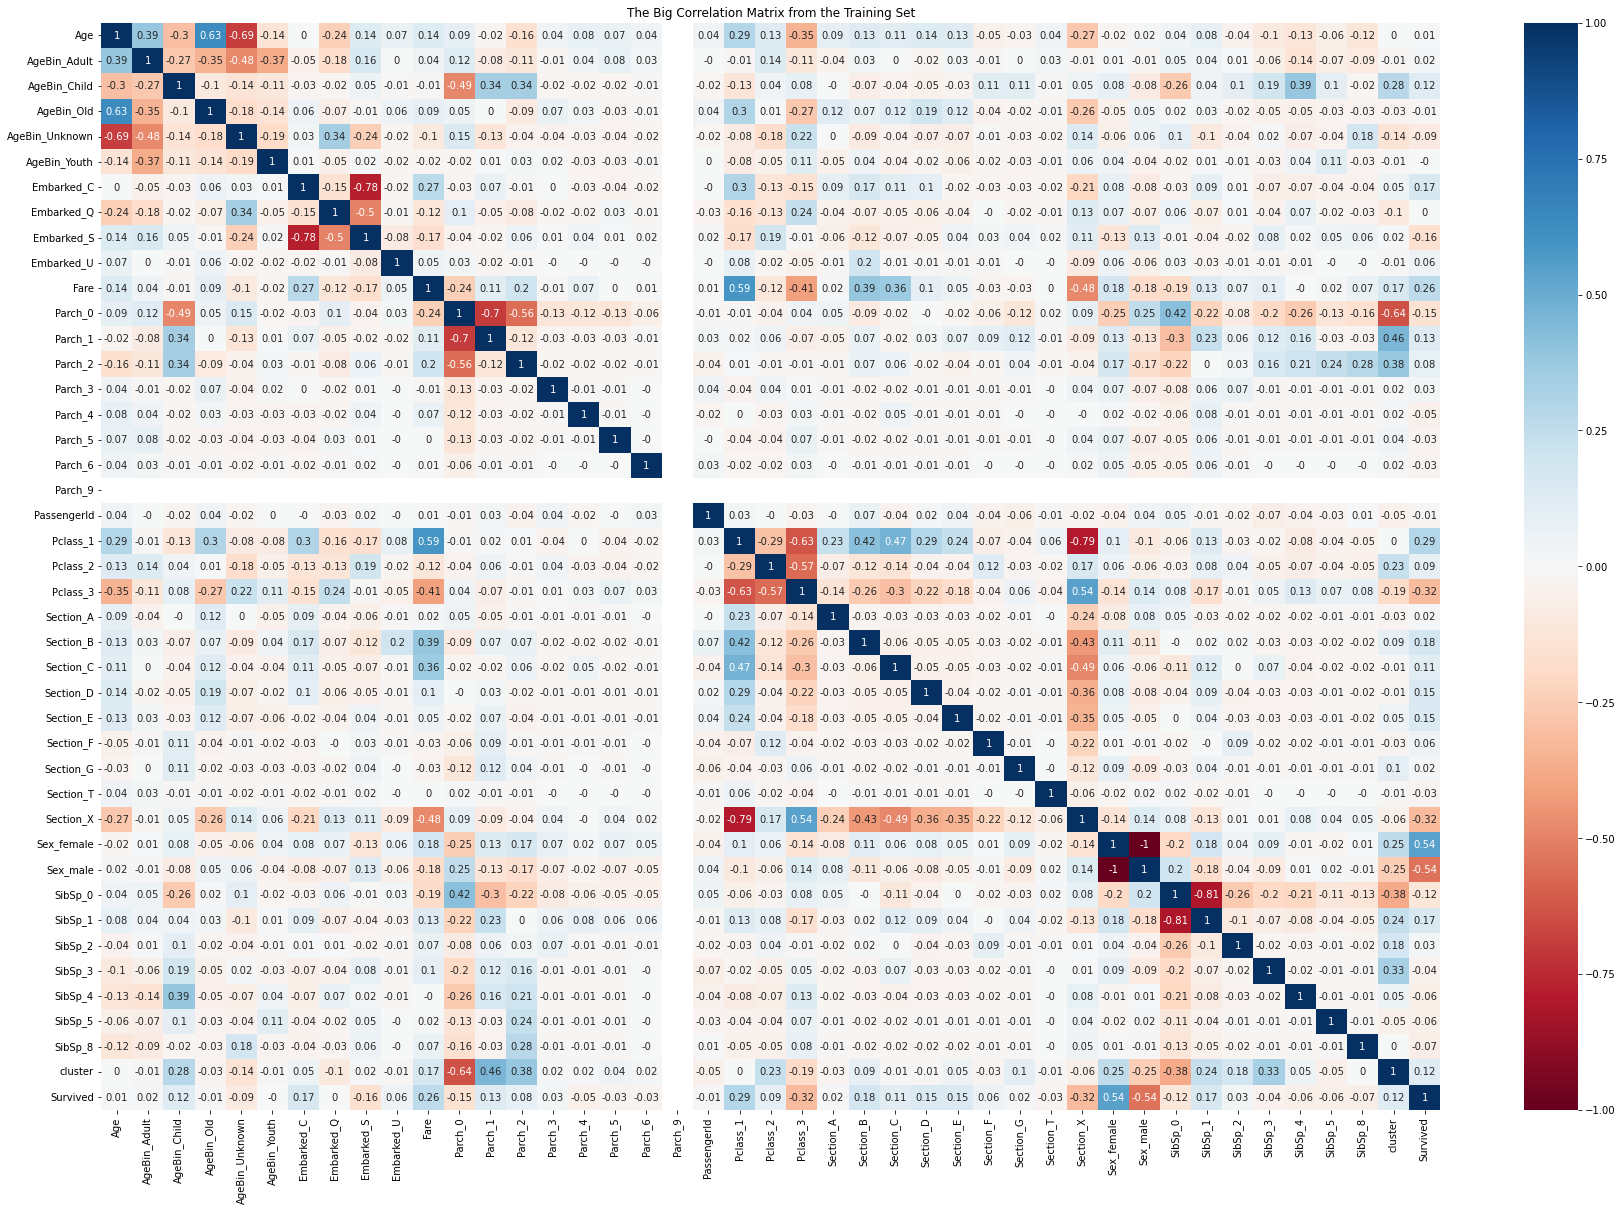

In [8]:
# plot a correlation matrix to get a clue
corr_m = train_data.corr(numeric_only=True).round(2)
plt.figure(figsize=(30,20))
plt.title("The Big Correlation Matrix from the Training Set")
sns.heatmap(corr_m, annot=True, cmap='RdBu')

### Quick test classification

In [9]:
dt = DecisionTreeClassifier()
X = train_data.drop(columns= ["Survived"])
y = train_data["Survived"]


In [10]:
X.head(10)

,Age,AgeBin_Adult,AgeBin_Child,AgeBin_Old,AgeBin_Unknown,AgeBin_Youth,Embarked_C,Embarked_Q,Embarked_S,Embarked_U,...,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,cluster
0,22.0,1,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,10
1,38.0,1,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,26.0,1,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1
3,35.0,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
4,35.0,1,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,1
5,-1.0,0,0,0,1,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,1
6,54.0,0,0,1,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,4
7,2.0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,23
8,27.0,1,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,18
9,14.0,0,0,0,0,1,1,0,0,0,...,1,0,0,1,0,0,0,0,0,12


In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20) 
dt.fit(xtrain, ytrain)
yhat = dt.predict(xtest)
print(f"Score is {dt.score(xtest, ytest):.3f}")
print(f"F1 score is {f1_score(ytest, yhat):.3f}")

Score is 0.709
F1 score is 0.629


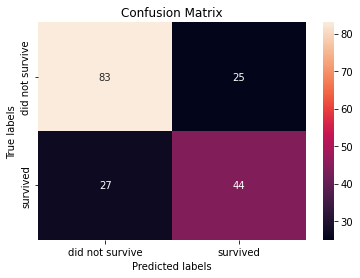

<Figure size 1440x1440 with 0 Axes>

In [12]:
plot_confusion_matrix(ytest, yhat)

### Cluster segregation experiment
Process the data by cluster to see if that's fruitfull.

In [13]:
clusters = train_data["cluster"].unique()
clusters.sort()
print(clusters)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [14]:
scores = {"Cluster": [],
          "F1_score" : [],
          "Score" : []
         }

for CL in clusters:
    X = train_data[train_data["cluster"] == CL].drop(columns="Survived")
    y = train_data[train_data["cluster"] == CL].Survived
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20) 
    dt.fit(xtrain, ytrain)
    yhat = dt.predict(xtest)
#    print(f"Cluster number {CL:d}")
    scores["Cluster"].append(CL)
    scores["Score"].append(dt.score(xtest, ytest))
    scores["F1_score"].append(f1_score(ytest, yhat))
                           
#    print(f"The shapes of things: xtrain = {xtrain.shape}, xtest = {xtest.shape}")
#    print("ytest", ytest)
#    print("yhat", yhat)
#    print(f"Score is {dt.score(xtest, ytest):.3f}")
#    print(f"F1 score is {f1_score(ytest, yhat):.3f}")
scores_df = pd.DataFrame(scores)
scores_df

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_cl

,Cluster,F1_score,Score
0,0,0.857143,0.818182
1,1,0.562500,0.784615
2,2,0.000000,0.333333
3,3,0.666667,0.600000
4,4,0.727273,0.727273
5,5,0.000000,1.000000
6,6,0.000000,1.000000
7,7,0.727273,0.714286
8,8,1.000000,1.000000
9,9,0.000000,0.500000


### Cluster Segregation Conclusion
Processing the data separately by cluster helps for some clusters but leaves so few data points in other clusters that prediction and scoring are unreliable.

### Create a baseline prediction based on Sex alone

Model score to beat based on sex alone is 0.70
Model F1 score to beat based on sex alone is 0.58


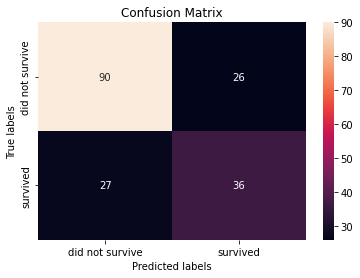

<Figure size 1440x1440 with 0 Axes>

In [15]:
SEX = train_data[["Sex_male","Sex_female"]]
YEX = train_data["Survived"]
xtrain, xtest, ytrain, ytest = train_test_split(SEX, YEX, test_size=0.20)
sex_rf = RandomForestClassifier()
sex_rf.fit(xtrain, ytrain)
yhat_sex = sex_rf.predict(xtest)
score_sex = sex_rf.score(xtest, ytest)
f1_sex = f1_score(ytest, yhat_sex)
print(f"Model score to beat based on sex alone is {score_sex:.2f}")
print(f"Model F1 score to beat based on sex alone is {f1_sex:.2f}")
plot_confusion_matrix(ytest, yhat_sex)

Check how adding in Age affects the prediction

Model score is 0.77
Model F1 score is 0.69


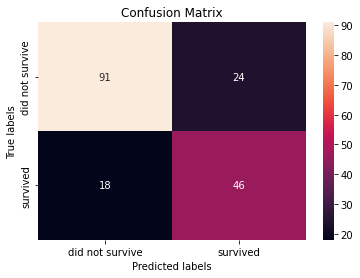

<Figure size 1440x1440 with 0 Axes>

In [16]:
SEX = train_data[["Age","Sex_male","Sex_female"]]
YEX = train_data["Survived"]
xtrain, xtest, ytrain, ytest = train_test_split(SEX, YEX, test_size=0.20)
sex_rf = RandomForestClassifier()
sex_rf.fit(xtrain, ytrain)
yhat_sex = sex_rf.predict(xtest)
score_sex = sex_rf.score(xtest, ytest)
f1_sex = f1_score(ytest, yhat_sex)
print(f"Model score is {score_sex:.2f}")
print(f"Model F1 score is {f1_sex:.2f}")
plot_confusion_matrix(ytest, yhat_sex)

Check how adding binned ages affects the prediciton

Model score is 0.78
Model F1 score is 0.71


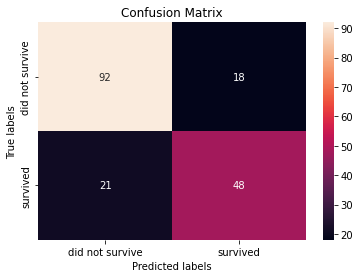

<Figure size 1440x1440 with 0 Axes>

In [17]:
SEX = train_data[["Sex_male","Sex_female", "AgeBin_Unknown","AgeBin_Child","AgeBin_Youth","AgeBin_Adult","AgeBin_Old"]]
YEX = train_data["Survived"]
xtrain, xtest, ytrain, ytest = train_test_split(SEX, YEX, test_size=0.20)
sex_rf = RandomForestClassifier()
sex_rf.fit(xtrain, ytrain)
yhat_sex = sex_rf.predict(xtest)
score_sex = sex_rf.score(xtest, ytest)
f1_sex = f1_score(ytest, yhat_sex)
print(f"Model score is {score_sex:.2f}")
print(f"Model F1 score is {f1_sex:.2f}")
plot_confusion_matrix(ytest, yhat_sex)

### Scaling the age column to prepare for other classifiers.

In [18]:
# Scale the data for better classification use with different methods
SS = preprocessing.StandardScaler()
SR = preprocessing.RobustScaler()
MM = preprocessing.MinMaxScaler()

In [19]:
y = train_data.Survived
XS = SS.fit_transform(train_data.drop(columns = ["Survived"]))
XR = SR.fit_transform(train_data.drop(columns = ["Survived"]))
XM = MM.fit_transform(train_data.drop(columns = ["Survived"]))
xstrain, xstest, ystrain, ystest = train_test_split(XS, y, test_size=0.20, random_state=2)
xrtrain, xrtest, yrtrain, yrtest = train_test_split(XR, y, test_size=0.20, random_state=2)
xmtrain, xmtest, ymtrain, ymtest = train_test_split(XM, y, test_size=0.20, random_state=2)


In [20]:
# Assign all gridsearch results to a dict with keys based on the type of scaler used 
grid_results = {"std_scale": list(rungrids(xstrain, xstest, ystrain, ystest)),
                "rob_scale": list(rungrids(xrtrain, xrtest, yrtrain, yrtest)),
                "minmax_scale": list(rungrids(xmtrain, xmtest, ymtrain, ymtest))
               }

Fitting logr-lbfgs
Fitting logr-linear
Fitting logr-newton-cg
Fitting dt
Fitting svm
Fitting knn
Fitting rf
Fitting sgd
Fitting logr-lbfgs
Fitting logr-linear
Fitting logr-newton-cg
Fitting dt
Fitting svm
Fitting knn
Fitting rf
Fitting sgd
Fitting logr-lbfgs
Fitting logr-linear
Fitting logr-newton-cg
Fitting dt
Fitting svm
Fitting knn
Fitting rf
Fitting sgd


Select the best model based on F1 score.

In [21]:
top_scores = {}
for ki in grid_results.keys():
    model_id = max(grid_results[ki][2]) # get the key for the top F1 score
    f1_ = grid_results[ki][2][model_id] # get the value for the top F1 score
    score_ = grid_results[ki][1][model_id] # get the value for the model score associated with the top F1 score
    top_scores[(ki, model_id)] = f1_ # save the model key and score to a dict

best_key = max(top_scores)
print("Best key is ", best_key)
print(f" The F1 score is {f1_:.3f} compared to the baseline sex only F1 score of {f1_sex:.3f}")
print(f" The model's score is {score_:.3f} compared to the baseline sex only model score of {score_sex:.3f}")
best_model = grid_results[best_key[0]][0][best_key[1]].best_estimator_
best_params = grid_results[best_key[0]][0][best_key[1]].best_params_

Best key is  ('std_scale', 'svm')
 The F1 score is 0.718 compared to the baseline sex only F1 score of 0.711
 The model's score is 0.793 compared to the baseline sex only model score of 0.782


In [22]:
best_model

SVC(max_iter=10000)

In [23]:
best_params

{'C': 1.0, 'kernel': 'rbf', 'max_iter': 10000}

In [24]:
# Scale the train data for output as final result
if best_key[0] == 'std_scale':
    test_scaled = SS.transform(test_data)
elif best_key[0] == 'rob_scale':
    test_scaled = SR.transform(test_data)
else:
    test_scaled = MM.transform(test_data)


Let's use the best estimator to make predicitons based on the test data provided.

In [25]:
test_hat = best_model.predict(test_scaled)

In [26]:
submission_data = pd.DataFrame(test_data.PassengerId)
submission_data.head()

,PassengerId
0,892
1,893
2,894
3,895
4,896


In [27]:
submission_data["Survived"] = test_hat

In [28]:
submission_data.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [29]:
# Write the submission file 
submission_data.to_csv("../kaggle/working/submission_data.csv", index=False)